In [231]:
# removes annoying deprecation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper #third party library to translate google query data to dataframe
import matplotlib.pyplot as plt
import os, sys

sys.path.insert(0, './../utils/')

# custom files 
import random_forest_regressor as rfr
import utilities as util
import validation as cv
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import train_test_split
from sklearn import cross_validation
import matplotlib.dates as mdates
from matplotlib import style
style.use('ggplot')

%matplotlib inline

with open('../../key.txt') as f:
    content = f.readlines()

#add your own key here 
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= content[0]

In [232]:
EPA_QUERY = """
        SELECT
            avg(CO_daily.arithmetic_mean) as COam,
            cast(EXTRACT(YEAR FROM CO_daily.date_local)*100 +
            EXTRACT(MONTH FROM CO_daily.date_local) as string) as COdate,
            avg(PPM_daily.arithmetic_mean) as PPMam,
            EXTRACT(YEAR FROM PPM_daily.date_local)*100 +
            EXTRACT(MONTH FROM PPM_daily.date_local) as PPMdate,
            avg(SO2_daily.arithmetic_mean) as SO2am,
            EXTRACT(YEAR FROM SO2_daily.date_local)*100 +
            EXTRACT(MONTH FROM SO2_daily.date_local) as SO2date,
            avg(NO2_daily.arithmetic_mean) as NO2am,
            EXTRACT(YEAR FROM NO2_daily.date_local)*100 +
            EXTRACT(MONTH FROM NO2_daily.date_local) as NO2date
        FROM
          `bigquery-public-data.epa_historical_air_quality.co_daily_summary` as CO_daily
          INNER JOIN `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary` as PPM_daily ON CO_daily.date_local = PPM_daily.date_local
          INNER JOIN `bigquery-public-data.epa_historical_air_quality.so2_daily_summary` as SO2_daily ON CO_daily.date_local = SO2_daily.date_local
          INNER JOIN `bigquery-public-data.epa_historical_air_quality.no2_daily_summary` as NO2_daily ON CO_daily.date_local = NO2_daily.date_local
        WHERE CO_daily.state_name ="California" AND CO_daily.city_name="San Francisco" AND
        PPM_daily.state_name ="California" AND PPM_daily.city_name="San Francisco" AND
        SO2_daily.state_name ="California" AND SO2_daily.city_name="San Francisco" AND
        NO2_daily.state_name ="California" AND NO2_daily.city_name="San Francisco"
        GROUP BY COdate, PPMdate, SO2date, NO2date
        ORDER BY COdate DESC
        """
bq_assistant = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_VISUAL = bq_assistant.query_to_pandas(EPA_QUERY)

In [233]:
df_VISUAL.head()

,COam,COdate,PPMam,PPMdate,SO2am,SO2date,NO2am,NO2date
0,0.574612,200812,13.371429,200812,1.826809,200812,23.572298,200812
1,0.475002,200811,11.100000,200811,1.141039,200811,20.358507,200811
2,0.596848,200810,12.110000,200810,1.772338,200810,26.621100,200810
3,0.378351,200809,9.620000,200809,0.887293,200809,14.808696,200809
4,0.289312,200808,7.680000,200808,0.645438,200808,10.114624,200808


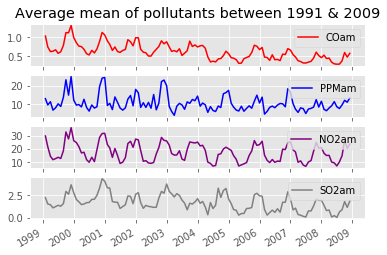

In [234]:
df_VISUAL['formatted_date'] = pd.to_datetime(df_VISUAL['COdate'], format='%Y%m')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
ax1.plot(df_VISUAL['formatted_date'], df_VISUAL['COam'], color='red')
ax2.plot(df_VISUAL['formatted_date'], df_VISUAL['PPMam'], color='blue')
ax3.plot(df_VISUAL['formatted_date'], df_VISUAL['NO2am'], color='purple')
ax4.plot(df_VISUAL['formatted_date'], df_VISUAL['SO2am'], color='gray')


fig.autofmt_xdate()
ax1.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax2.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax3.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax4.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax1.set_title('Average mean of pollutants between 1991 & 2009')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')


Text(0.5,0,'Year')

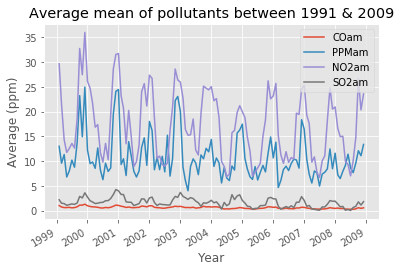

In [235]:
fig, ax = plt.subplots()
ax.plot(df_VISUAL['formatted_date'], df_VISUAL['COam'])
ax.plot(df_VISUAL['formatted_date'], df_VISUAL['PPMam'])
ax.plot(df_VISUAL['formatted_date'], df_VISUAL['NO2am'])
ax.plot(df_VISUAL['formatted_date'], df_VISUAL['SO2am'])

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Average mean of pollutants between 1991 & 2009')
ax.legend(loc='upper right')
ax.set_ylabel('Average (ppm)')
ax.set_xlabel('Year')

In [236]:
SF_CRIME_QUERY = """
        SELECT
            COUNT( DISTINCT unique_key) as count,
            cast(EXTRACT(YEAR FROM SFCrimeData.timestamp)*100 +
            EXTRACT(MONTH FROM SFCrimeData.timestamp) as string) as date
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE category != "NON-CRIMINAL" AND category != "RECOVERED VEHICLE"
        GROUP BY date
        ORDER BY date DESC
        """

bq_assistant_SF_crime = BigQueryHelper("bigquery-public-data", "san_francisco_sfpd_incidents.sfpd_incidents")
df_SF_crime_VISUAL = bq_assistant_SF_crime.query_to_pandas(SF_CRIME_QUERY)
df_SF_census = pd.read_csv('../../data/censuspopulationsf.tsv', sep='\t', header=None)
df_SF_census.columns = ['year', 'pop']
util.per_capita(df_SF_crime_VISUAL, df_SF_census)
df_SF_crime_VISUAL['per_capita'] *=100000
df_SF_crime_VISUAL.head()

,count,date,per_capita
0,2377,201805,268.781032
1,6929,201804,783.501797
2,7202,201803,814.371474
3,6664,201802,753.536726
4,8182,201801,925.185699


Text(0.5,0,'Year')

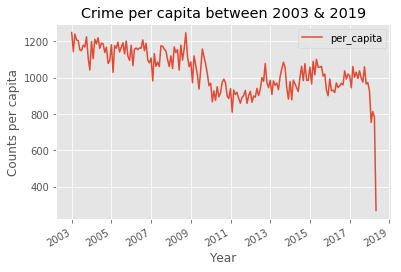

In [237]:
fig, ax = plt.subplots()
df_SF_crime_VISUAL['formatted_date'] = pd.to_datetime(df_SF_crime_VISUAL['date'], format='%Y%m')
ax.plot(df_SF_crime_VISUAL['formatted_date'], df_SF_crime_VISUAL['per_capita'])
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Crime per capita between 2003 & 2019')
ax.legend(loc='upper right')
ax.set_ylabel('Counts per capita')
ax.set_xlabel('Year')

Text(0.5,0,'Crime per capita')

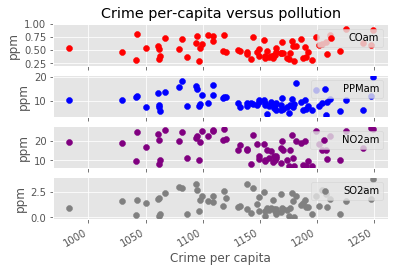

In [238]:
df_VISUAL.rename(columns={'COdate': 'date'}, inplace=True)
df_merged_VISUAL = util.merge_data(df_VISUAL[['date', 'COam', 'PPMam', 'SO2am', 'NO2am']], df_SF_crime_VISUAL)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
ax1.scatter( df_merged_VISUAL['per_capita'], df_merged_VISUAL['COam'] , color='red')
ax2.scatter(df_merged_VISUAL['per_capita'], df_merged_VISUAL['PPMam'],  color='blue')
ax3.scatter(df_merged_VISUAL['per_capita'], df_merged_VISUAL['NO2am'], color='purple')
ax4.scatter(df_merged_VISUAL['per_capita'], df_merged_VISUAL['SO2am'], color='gray')


# fig.set_size_inches(18.5, 10.5)

fig.autofmt_xdate()

ax1.set_title('Crime per-capita versus pollution')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

ax1.set_ylabel('ppm')
ax2.set_ylabel('ppm')
ax3.set_ylabel('ppm')
ax4.set_ylabel('ppm')
ax4.set_xlabel('Crime per capita')

In [239]:
EPA_QUERY = """
        SELECT
            avg(CO_daily.arithmetic_mean) as COam,
            cast(EXTRACT(YEAR FROM CO_daily.date_local)*10000 +
            EXTRACT(MONTH FROM CO_daily.date_local)*100 + 
            EXTRACT(DAY FROM CO_daily.date_local) as string) as COdate,
            avg(PPM_daily.arithmetic_mean) as PPMam,
            EXTRACT(YEAR FROM PPM_daily.date_local)*10000 +
            EXTRACT(MONTH FROM PPM_daily.date_local)*100 + 
            EXTRACT(DAY FROM PPM_daily.date_local) as PPMdate,
            avg(SO2_daily.arithmetic_mean) as SO2am,
            EXTRACT(YEAR FROM SO2_daily.date_local)*10000 +
            EXTRACT(MONTH FROM SO2_daily.date_local)*100 + 
            EXTRACT(DAY FROM SO2_daily.date_local) as SO2date,
            avg(NO2_daily.arithmetic_mean) as NO2am,
            EXTRACT(YEAR FROM NO2_daily.date_local)*10000 +
            EXTRACT(MONTH FROM NO2_daily.date_local)*100 + 
            EXTRACT(DAY FROM NO2_daily.date_local) as NO2date
        FROM
          `bigquery-public-data.epa_historical_air_quality.co_daily_summary` as CO_daily
          INNER JOIN `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary` as PPM_daily ON CO_daily.date_local = PPM_daily.date_local
          INNER JOIN `bigquery-public-data.epa_historical_air_quality.so2_daily_summary` as SO2_daily ON CO_daily.date_local = SO2_daily.date_local
          INNER JOIN `bigquery-public-data.epa_historical_air_quality.no2_daily_summary` as NO2_daily ON CO_daily.date_local = NO2_daily.date_local
        WHERE CO_daily.state_name ="California" AND CO_daily.city_name="San Francisco" AND
        PPM_daily.state_name ="California" AND PPM_daily.city_name="San Francisco" AND
        SO2_daily.state_name ="California" AND SO2_daily.city_name="San Francisco" AND
        NO2_daily.state_name ="California" AND NO2_daily.city_name="San Francisco"
        GROUP BY COdate, PPMdate, SO2date, NO2date
        ORDER BY COdate DESC
        """
bq_assistant = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_POLLUTION = bq_assistant.query_to_pandas(EPA_QUERY)

In [240]:
df_POLLUTION.head()

,COam,COdate,PPMam,PPMdate,SO2am,SO2date,NO2am,NO2date
0,0.410598,20081220,7.0,20081220,2.500000,20081220,19.450000,20081220
1,0.415399,20081217,6.5,20081217,1.669481,20081217,24.238095,20081217
2,0.327898,20081214,4.7,20081214,0.227922,20081214,16.608696,20081214
3,0.773279,20081211,22.1,20081211,2.962987,20081211,29.952381,20081211
4,0.618206,20081208,18.6,20081208,1.397403,20081208,22.863636,20081208


In [241]:
SF_CRIME_QUERY = """
        SELECT
            COUNT( DISTINCT unique_key) as count,
            cast(EXTRACT(YEAR FROM SFCrimeData.timestamp)*10000 +
            EXTRACT(MONTH FROM SFCrimeData.timestamp)*100 + 
            EXTRACT(DAY FROM SFCrimeData.timestamp) as string) as date
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE category != "NON-CRIMINAL" AND category != "RECOVERED VEHICLE"
        GROUP BY date
        ORDER BY date DESC
        """

bq_assistant_SF_crime = BigQueryHelper("bigquery-public-data", "san_francisco_sfpd_incidents.sfpd_incidents")
df_SF_crime = bq_assistant_SF_crime.query_to_pandas(SF_CRIME_QUERY)

In [242]:
df_SF_census = pd.read_csv('../../data/censuspopulationsf.tsv', sep='\t', header=None)
df_SF_census.columns = ['year', 'pop']
df_SF_census.head(n=20)

,year,pop
0,2003,757638
1,2004,750133
2,2005,748846
3,2006,751431
4,2007,758348
5,2008,767067
6,2009,774347
7,2010,805770
8,2011,816294
9,2012,830406


In [243]:
# make column for counts per capita
util.per_capita(df_SF_crime, df_SF_census)
df_SF_crime['per_capita'] *=100000
# merge CO and Crime data
df_POLLUTION.rename(columns={'COdate': 'date'}, inplace=True)
df_merged = util.merge_data(df_POLLUTION[['date', 'COam', 'PPMam', 'SO2am', 'NO2am']], df_SF_crime)
df_merged.head()

,date,COam,PPMam,SO2am,NO2am,count,per_capita
3432,20081220,0.410598,7.0,2.500000,19.450000,329,42.890647
3435,20081217,0.415399,6.5,1.669481,24.238095,266,34.677544
3438,20081214,0.327898,4.7,0.227922,16.608696,202,26.334075
3441,20081211,0.773279,22.1,2.962987,29.952381,277,36.111578
3444,20081208,0.618206,18.6,1.397403,22.863636,271,35.329378


In [244]:
# find optimum regressor
regr = rfr.find_regressor(df_merged[['date', 'COam', 'PPMam', 'SO2am', 'NO2am']].as_matrix(), df_merged['per_capita'].values)
regr

/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.0s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.1s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.1s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True, total=   1.2s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootst

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=275, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [245]:
# split dataset 
X_train, X_test, y_train, y_test = train_test_split(df_merged[['date', 'COam', 'PPMam', 'SO2am', 'NO2am']], df_merged['per_capita'].values, test_size=0.33, random_state=42)
# make predictions based on optimum regressor
y_pred = rfr.fit_and_predict(regr, X_train, X_test, y_train, y_test)

./../utils/random_forest_regressor.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  regr.fit(X_train.as_matrix(), y_train)
./../utils/random_forest_regressor.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return regr.predict(X_test.as_matrix())


In [246]:
cv.MSE(y_test, y_pred)
# leave one out cross validation 
# loo = cross_validation.LeaveOneOut(len(df_merged['per_capita'].values))
# loo_score = cv.Cross_Validation(loo, regr, df_merged[['date','am']].as_matrix(), df_merged['per_capita'].values)

16.16167010328121

In [247]:
# 10 fold tss cross validation
tss_score = cv.Cross_Validation(df_merged[['date', 'COam', 'PPMam', 'SO2am', 'NO2am']], df_merged['per_capita'], regr, 10)
print('10-fold cross validation using time series split (additive): {} '.format(tss_score))

10-fold cross validation using time series split (additive): 24.991608413099627 


In [248]:
df_merged.corr()

,COam,PPMam,SO2am,NO2am,count,per_capita
COam,1.000000,0.509747,0.619965,0.802885,0.140665,0.145777
PPMam,0.509747,1.000000,0.608483,0.589155,0.034015,0.036684
SO2am,0.619965,0.608483,1.000000,0.726470,0.092678,0.098598
NO2am,0.802885,0.589155,0.726470,1.000000,0.148181,0.147951
count,0.140665,0.034015,0.092678,0.148181,1.000000,0.998241
per_capita,0.145777,0.036684,0.098598,0.147951,0.998241,1.000000


Text(0.5,1,'Predicted crime per capita')

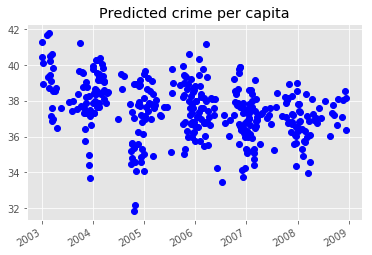

In [251]:
X_test['formatted_date'] = pd.to_datetime(X_test['date'], format='%Y%m%d')
# plot original data 
fig, ax = plt.subplots()
ax.plot(X_test['formatted_date'], y_pred, 'bo')
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# n = 10
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.set_title('Predicted crime per capita')

Text(0.5,1,'Residual plot (using data from total pollution vs crime)')

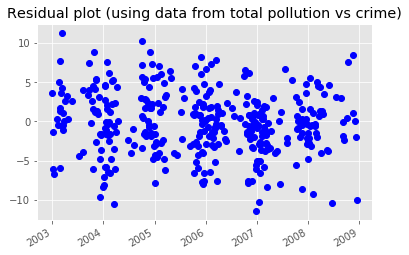

In [253]:
residuals = y_test - y_pred
fig, ax = plt.subplots()
ax.plot(X_test['formatted_date'], residuals, 'bo')
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# n = 10
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.set_title('Residual plot (using data from total pollution vs crime)')